In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_squared_error

In [2]:
def quat_to_euler(quat):
    # Converts a quaternion matrix [w, x, y, z] into an Euler angle [roll, pitch, yaw] matrix
    euler = np.zeros(shape=(quat.shape[0], 3))
    for i in range(quat.shape[0]):
        qw, qx, qy, qz = quat[i, :]
        roll = np.arctan2(2*(qw*qx+qy*qz), 1-2*(qx**2+qy**2))
        pitch = -np.pi/2 + 2*np.arctan2(np.sqrt(1+2*(qw*qy-qx*qz)), np.sqrt(1-2*(qw*qy-qx*qz)))
        yaw = np.arctan2(2*(qw*qz+qx*qy), 1-2*(qy**2+qz**2))
        euler[i,:] = [roll, pitch, yaw]
    return euler

In [3]:
def test_model(traj, model, data_params):
    # GPS
    gps_pos = traj['gps']['position']
    # Ground truth
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    # Get average IMU data for each timestep of GPS data (IMU 100Hz, GPS 1Hz)
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    avg_acc = np.zeros(shape=(imu_sumdiv+1,3))
    avg_acc[0,:] = imu_acc[0,:]
    avg_gyr = np.zeros(shape=(imu_sumdiv+1,3))
    avg_gyr[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        avg_acc[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        avg_gyr[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)

    # Normalie IMU and attitude data
    if data_params["NORMALIZE_INPUT"]:
        avg_acc = (avg_acc - data_params["acc_mean"])/data_params["acc_std"]
        avg_gyr = (avg_gyr - data_params["gyr_mean"])/data_params["gyr_std"]
        gnd_att = (gnd_att - data_params["att_mean"])/data_params["att_std"]
    
    # Change in GPS position
    delta_gps_pos = gps_pos[1:,:] - gps_pos[:-1,:]
    delta_gps_pos = np.vstack((np.zeros(shape=(1,3)), delta_gps_pos))

    # Normalize GPS change output
    if data_params["NORMALIZE_OUTPUT"]:
        delta_gps_pos = (delta_gps_pos - data_params["gps_mean"])/data_params["gps_std"]

    dp_ = delta_gps_pos.shape[0]
    Y_pred_ = np.zeros(shape=(dp_,3))
    for i in range(dp_):
        if i <= data_params["MODEL_DELAY"]:
            # STILL NEED MORE DATA
            Y_pred_[i,:] = delta_gps_pos[i,:]
        else:
            # ENOUGH DATA
            X_ = np.zeros(shape=(1,0))
            if data_params["INPUT_ACCL"]:
                X_ = np.hstack((X_, [avg_acc[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_GYRO"]:
                X_ = np.hstack((X_, [avg_gyr[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            if data_params["INPUT_ATTI"]:
                X_ = np.hstack((X_, [gnd_att[(i-data_params["MODEL_DELAY"]-1)*100:(i-1)*100:100,:].flatten()]))
            if data_params["INPUT_POUT"]:
                X_ = np.hstack((X_, [Y_pred_[i-data_params["MODEL_DELAY"]-1:i-1,:].flatten()]))
            Y_ = model(X_)
            Y_pred_[i,:] = Y_
    return Y_pred_, delta_gps_pos

In [41]:
f = h5py.File('data/drone_sim/sunny.hdf5')
train_set = ['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009',
             '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019']

MODEL_DELAY = 1
NORMALIZE_INPUT = True
NORMALIZE_OUTPUT = True
INPUT_ACCL = True
INPUT_GYRO = True
INPUT_ATTI = True
INPUT_POUT = True

data_params = {"MODEL_DELAY": MODEL_DELAY, 
               "NORMALIZE_INPUT": NORMALIZE_INPUT, 
               "NORMALIZE_OUTPUT": NORMALIZE_OUTPUT, 
               "INPUT_ACCL": INPUT_ACCL, 
               "INPUT_GYRO": INPUT_GYRO, 
               "INPUT_ATTI": INPUT_ATTI, 
               "INPUT_POUT": INPUT_POUT
}

"""Autoregressive exogeneous model trainset creation"""
# Construct training data set
Y_train = np.zeros(shape=(0,3))
features = (INPUT_ACCL + INPUT_ATTI + INPUT_GYRO + INPUT_POUT)*3*MODEL_DELAY
X_train = np.zeros(shape=(0,features))
for i, traj_num in enumerate(train_set):
    # Extract trajectory information from HDF5 file
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    # GPS
    gps_pos = traj['gps']['position']
    # Ground truth
    gnd_att = quat_to_euler(traj['groundtruth']['attitude'])
    # IMU unit
    imu_acc = traj['imu']['accelerometer']
    imu_gyr = traj['imu']['gyroscope']

    # Get average IMU data for each timestep of GPS data (IMU 100Hz, GPS 1Hz)
    imu_sumdiv = int(np.floor(imu_acc.shape[0]/100))
    avg_acc = np.zeros(shape=(imu_sumdiv+1,3))
    avg_acc[0,:] = imu_acc[0,:]
    avg_gyr = np.zeros(shape=(imu_sumdiv+1,3))
    avg_gyr[0,:] = imu_gyr[0,:]

    for i in range(imu_sumdiv):
        avg_acc[i+1,:] = np.average(imu_acc[1+100*i:1+100*(i+1),:], axis=0)
        avg_gyr[i+1,:] = np.average(imu_gyr[1+100*i:1+100*(i+1),:], axis=0)

    # Normalie IMU and attitude data
    if NORMALIZE_INPUT:
        acc_mean = np.mean(avg_acc, axis=0)
        data_params["acc_mean"] = acc_mean
        acc_std  = np.std(avg_acc, axis=0)
        data_params["acc_std"] = acc_std
        gyr_mean = np.mean(avg_gyr, axis=0)
        data_params["gyr_mean"] = gyr_mean
        gyr_std  = np.std(avg_gyr, axis=0)
        data_params["gyr_std"] = gyr_std
        att_mean = np.mean(gnd_att, axis=0)
        data_params["att_mean"] = att_mean
        att_std  = np.std(gnd_att, axis=0)
        data_params["att_std"] = att_std

        avg_acc = (avg_acc - acc_mean)/acc_std
        avg_gyr = (avg_gyr - gyr_mean)/gyr_std
        gnd_att = (gnd_att - att_mean)/att_std
    
    # Change in GPS position
    delta_gps_pos = gps_pos[1:,:] - gps_pos[:-1,:]
    delta_gps_pos = np.vstack((np.zeros(shape=(1,3)), delta_gps_pos))

    # Normalize GPS change output
    if NORMALIZE_OUTPUT:
        gps_mean = np.mean(delta_gps_pos, axis=0)
        data_params["gps_mean"] = gps_mean
        gps_std  = np.std(delta_gps_pos, axis=0)
        data_params["gps_std"] = gps_std

        delta_gps_pos = (delta_gps_pos - gps_mean)/gps_std

    # Construct training set
    dp_ = delta_gps_pos.shape[0]-MODEL_DELAY
    Y_train_ = np.zeros(shape=(dp_, 3))
    X_train_ = np.zeros(shape=(dp_, features))
    for i in range(dp_):
        Y_ = delta_gps_pos[i+MODEL_DELAY,:]
        Y_train_[i,:] = Y_
        X_ = np.zeros(shape=(1,0))
        if INPUT_ACCL:
            X_ = np.hstack((X_, [avg_acc[i:i+MODEL_DELAY,:].flatten()]))
        if INPUT_GYRO:
            X_ = np.hstack((X_, [avg_gyr[i:i+MODEL_DELAY,:].flatten()]))
        if INPUT_ATTI:
            X_ = np.hstack((X_, [gnd_att[i*100:(i+MODEL_DELAY)*100:100,:].flatten()]))
        if INPUT_POUT:
            X_ = np.hstack((X_, [delta_gps_pos[i:i+MODEL_DELAY,:].flatten()]))
        X_train_[i,:] = X_
    
    # Add to X and Y sets
    X_train = np.vstack((X_train, X_train_))
    Y_train = np.vstack((Y_train, Y_train_))


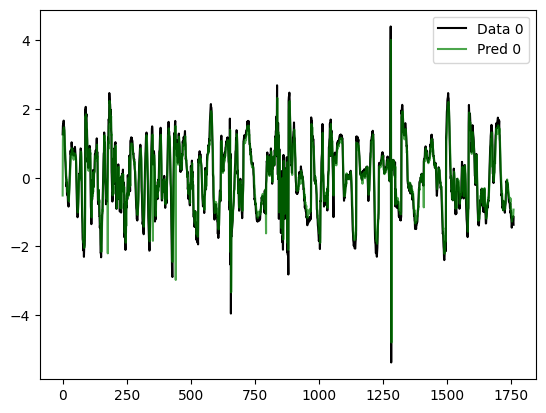

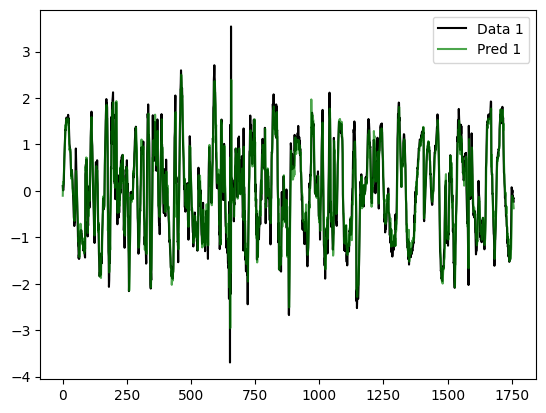

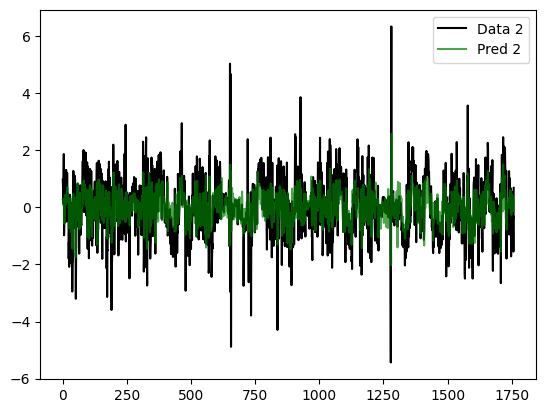

In [47]:
"""Least-squares fitting"""
# Train LS model
BETA_REG = 10
dp_, features_ = X_train.shape
_, outputs_ = Y_train.shape
w_ls = np.zeros(shape=(outputs_, features_, 1))
Y_train_ls = np.zeros(shape=(dp_, outputs_))
for i in range(outputs_):
    w_ls[i,:,:] = np.expand_dims(np.linalg.inv(X_train.T @ X_train + BETA_REG*np.eye(X_train.shape[1])) @ X_train.T @ Y_train[:,i], axis=1)
    Y_train_ls[:,i] = (X_train @ w_ls[i,:,:]).flatten()

def model_ls(x):
    outputs_, _, _ = w_ls.shape
    dp_, _ = x.shape
    y_ = np.zeros(shape=(dp_, outputs_))
    for i in range(outputs_):
        y_[:,i] = (x @ w_ls[i,:,:]).flatten()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_ls[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

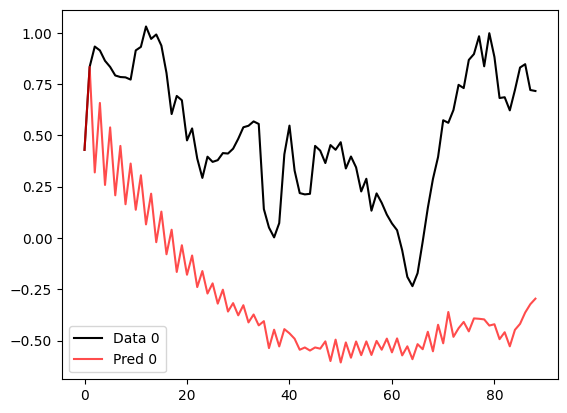

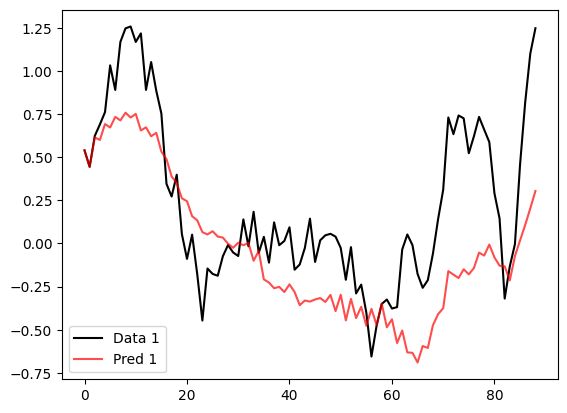

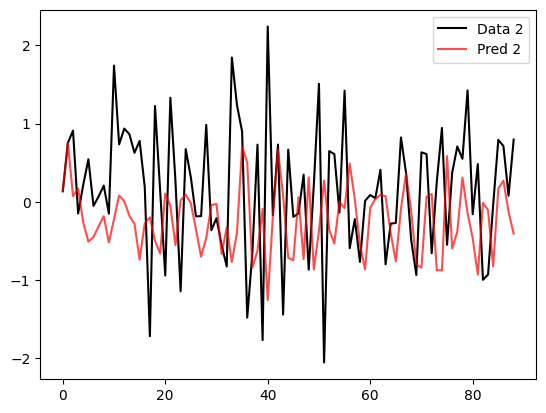

In [48]:
"""Least squares testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0029"]
Y_test_ls, Y_test = test_model(traj=traj, model=model_ls, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_ls[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

Epoch 1, training loss: 1.0520
Epoch 100, training loss: 0.3060
Epoch 200, training loss: 0.3326
Epoch 300, training loss: 0.2287
Epoch 400, training loss: 0.1960
Epoch 500, training loss: 0.2181
Epoch 600, training loss: 0.0979
Epoch 700, training loss: 0.0738
Epoch 800, training loss: 0.0679
Epoch 900, training loss: 0.0512
Epoch 1000, training loss: 0.0405
Epoch 1100, training loss: 0.0407
Epoch 1200, training loss: 0.0317
Epoch 1300, training loss: 0.0319
Epoch 1400, training loss: 0.0300
Epoch 1500, training loss: 0.0222
Epoch 1600, training loss: 0.0251
Epoch 1700, training loss: 0.0239
Epoch 1800, training loss: 0.0268
Epoch 1900, training loss: 0.0215
Epoch 2000, training loss: 0.0202
Epoch 2100, training loss: 0.0137
Epoch 2200, training loss: 0.0268
Epoch 2300, training loss: 0.0116
Epoch 2400, training loss: 0.0229
Epoch 2500, training loss: 0.0119
Epoch 2600, training loss: 0.0138
Epoch 2700, training loss: 0.0105
Epoch 2800, training loss: 0.0096
Epoch 2900, training loss:

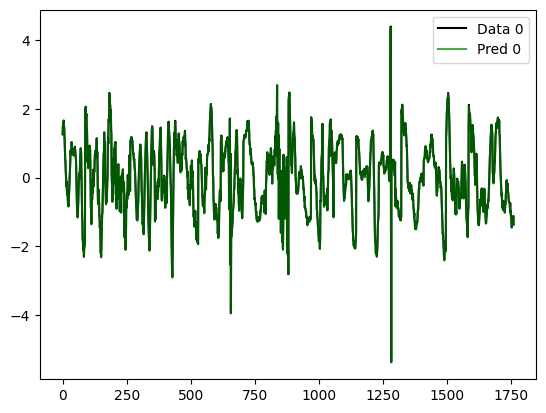

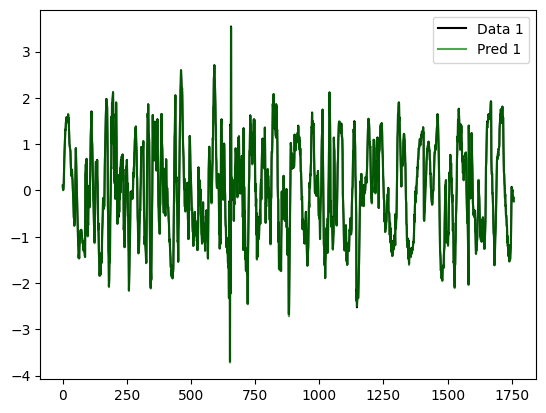

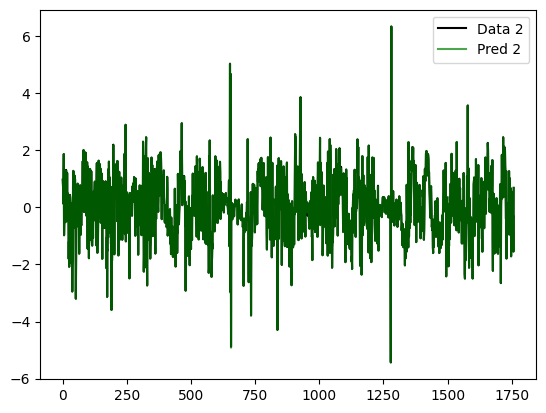

In [49]:
"""Neural network training"""
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_train).to(torch.float32)

dp, features = X_train_tensor.shape
_, outputs = Y_train_tensor.shape

NUM_HIDDEN_LAYERS = 128
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
WEIGHT_DECAY = 0
NUM_EPOCHS = 50000

# Define model, loss function, and search algorithm
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=features, out_features=NUM_HIDDEN_LAYERS),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=NUM_HIDDEN_LAYERS, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=8),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=8, out_features=outputs)
)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Train model
model.train()
for epoch in range(1, NUM_EPOCHS+1):
    Y_pred_ = model(X_train_tensor)
    loss_value = loss(Y_pred_, Y_train_tensor)

    model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or ((epoch % 100) == 0):
        print(f"Epoch {epoch}, training loss: {loss_value.item():.4f}")

# Evaluate train set
model.eval()
with torch.no_grad():
    Y_train_nn = model(X_train_tensor).numpy()

def model_nn(x):
    x_tensor = torch.from_numpy(x).to(torch.float32)
    model.eval()
    with torch.no_grad():
        y_ = model(x_tensor).numpy()
    return y_

for i in range(Y_train.shape[1]):
    plt.figure()
    plt.plot(Y_train[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_train_nn[:,i], c="green", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

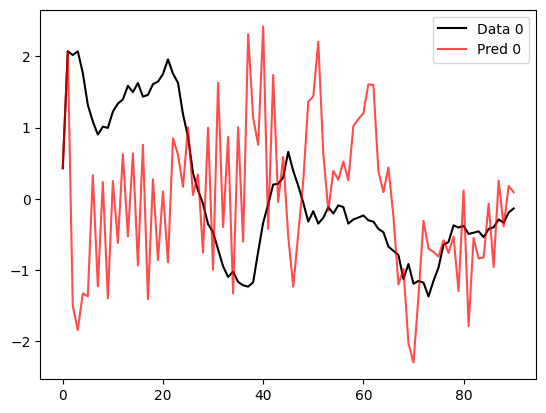

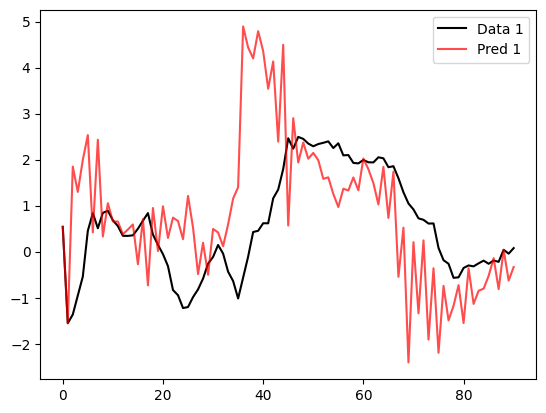

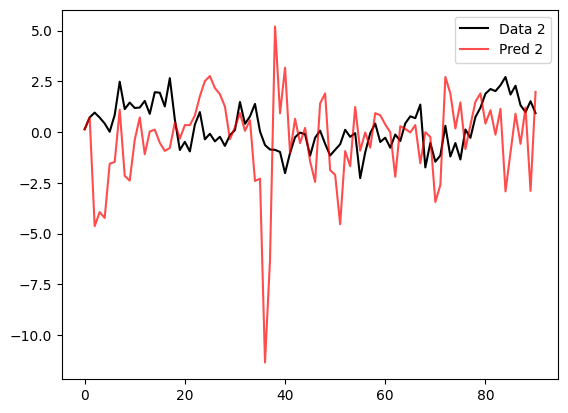

In [50]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
traj = f["trajectory_0024"]
Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)

for i in range(Y_test.shape[1]):
    plt.figure()
    plt.plot(Y_test[:,i], c="black", label=f"Data {i}")
    plt.plot(Y_test_nn[:,i], c="red", alpha=0.7, label=f"Pred {i}")
    plt.legend()
plt.show()

In [38]:
"""Neural network testing"""
f = h5py.File('data/drone_sim/sunny.hdf5')
test_set = ['0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029']
mse_ls_avg = np.zeros(shape=(3,))
mse_nn_avg = np.zeros(shape=(3,))
for traj_num in test_set:
    traj_name = f"trajectory_{traj_num}"
    traj = f[traj_name]
    Y_test_nn, Y_test = test_model(traj=traj, model=model_nn, data_params=data_params)
    Y_test_ls, _ = test_model(traj=traj, model=model_ls, data_params=data_params)
    
    mse_ls = mean_squared_error(Y_test, Y_test_ls, multioutput="raw_values")
    mse_nn = mean_squared_error(Y_test, Y_test_nn, multioutput="raw_values")
    
    mse_ls_avg = mse_ls_avg + mse_ls
    mse_nn_avg = mse_nn_avg + mse_nn

    print(f"\nTraj_{traj_num}")
    print(f"LS: x:{mean_squared_error(Y_test[:,0], Y_test_ls[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_ls[:,1]):.4f}")
    print(f"NN: x:{mean_squared_error(Y_test[:,0], Y_test_nn[:,0]):.4f} y:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}, z:{mean_squared_error(Y_test[:,1], Y_test_nn[:,1]):.4f}")
mse_ls_avg = mse_ls_avg/len(test_set)
mse_nn_avg = mse_nn_avg/len(test_set)

print(f"NN: {mse_nn_avg}")
print(f"LS: {mse_ls_avg}")


Traj_0020
LS: x:0.6682 y:2.2541, z:2.2541
NN: x:1.3992 y:3.5251, z:3.5251

Traj_0021
LS: x:2.0612 y:2.5040, z:2.5040
NN: x:5.5372 y:1.9440, z:1.9440

Traj_0022
LS: x:0.2612 y:0.7506, z:0.7506
NN: x:4.8097 y:1.1239, z:1.1239

Traj_0023
LS: x:0.8607 y:1.5359, z:1.5359
NN: x:2.6836 y:3.5782, z:3.5782

Traj_0024
LS: x:0.3476 y:2.7033, z:2.7033
NN: x:4.4951 y:4.4174, z:4.4174

Traj_0025
LS: x:1.2846 y:0.4007, z:0.4007
NN: x:4.9413 y:0.5263, z:0.5263

Traj_0026
LS: x:0.5946 y:0.5431, z:0.5431
NN: x:3.0576 y:0.3267, z:0.3267

Traj_0027
LS: x:0.3275 y:0.9857, z:0.9857
NN: x:2.6400 y:1.3138, z:1.3138

Traj_0028
LS: x:0.5918 y:1.0223, z:1.0223
NN: x:2.5011 y:0.4869, z:0.4869

Traj_0029
LS: x:0.8788 y:0.7426, z:0.7426
NN: x:5.3362 y:1.1006, z:1.1006
NN: [ 3.74009829  1.83428821 19.42138393]
LS: [0.7876271  1.34421689 0.9927943 ]
